In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# 1. Load and preprocess the dataset
ds = load_dataset("riotu-lab/Synthetic-UAV-Flight-Trajectories")
data = ds["train"]
positions = np.stack([data["tx"], data["ty"], data["tz"]], axis=1)  # shape: (766140, 3)

SEQ_LEN = 20
X, y = [], []
for i in range(len(positions) - SEQ_LEN):
    X.append(positions[i:i+SEQ_LEN])
    y.append(positions[i+SEQ_LEN])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 2. Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# 3. Dataset and Dataloaders
class TrajectoryDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TrajectoryDataset(X_train, y_train), batch_size=32, shuffle=True)
print('train', train_loader.batch_size)
val_loader   = DataLoader(TrajectoryDataset(X_val, y_val), batch_size=32, shuffle=False)
print('val', val_loader.batch_size)
test_loader  = DataLoader(TrajectoryDataset(X_test, y_test), batch_size=32, shuffle=False)
print('test', test_loader.batch_size)

# 4. Model definition
class RNNPredictor(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 3)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 5. Training with early stopping
best_val_loss = float("inf")
patience = 3
patience_counter = 0
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    print(f"Epoch {epoch+1}/{EPOCHS}")
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch_x, batch_y in pbar:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✨ New best model saved.")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break

# 6. Test Evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"\n🧪 Final Test Loss: {test_loss:.4f}")


Resolving data files:   0%|          | 0/5093 [00:00<?, ?it/s]

/var/folders/1c/dzyc5dfn4mdbcgcx9y09h8g00000gn/T/ipykernel_65767/4065066231.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  X = torch.tensor(X, dtype=torch.float32)


train 32
val 32
test 32
Epoch 1/50


Train Loss: 12.0129 | Val Loss: 5.4214
✨ New best model saved.
Epoch 2/50


Train Loss: 4.5925 | Val Loss: 5.4084
✨ New best model saved.
Epoch 3/50


Train Loss: 4.5672 | Val Loss: 5.3977
✨ New best model saved.
Epoch 4/50


Train Loss: 4.5563 | Val Loss: 5.3327
✨ New best model saved.
Epoch 5/50


Train Loss: 4.5467 | Val Loss: 5.3119
✨ New best model saved.
Epoch 6/50


Train Loss: 4.5420 | Val Loss: 5.3069
✨ New best model saved.
Epoch 7/50


Train Loss: 4.5354 | Val Loss: 5.3020
✨ New best model saved.
Epoch 8/50


Train Loss: 4.5307 | Val Loss: 5.5047
⏳ Patience: 1/3
Epoch 9/50


Train Loss: 4.5279 | Val Loss: 5.3256
⏳ Patience: 2/3
Epoch 10/50


Train Loss: 4.5238 | Val Loss: 5.3057
⏳ Patience: 3/3
🛑 Early stopping triggered.

🧪 Final Test Loss: 5.0625


Sample 36189: True Position: [ 5.476089  5.005249 14.640697] | Predicted Position: [[ 5.426986  4.809933 14.672382]]


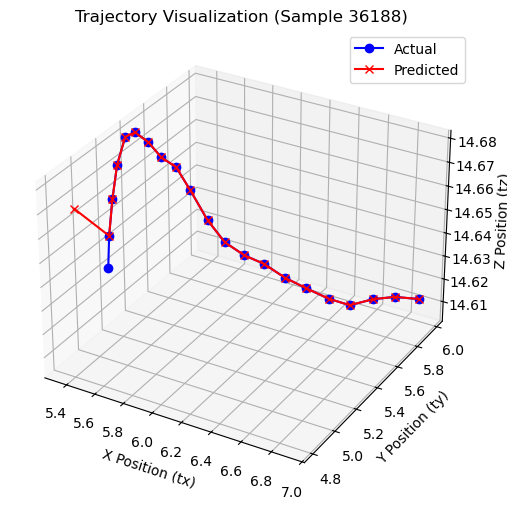

Sample 746773: True Position: [-1.1895396 25.429451   7.1995835] | Predicted Position: [[-0.83579355 25.302053    7.157602  ]]


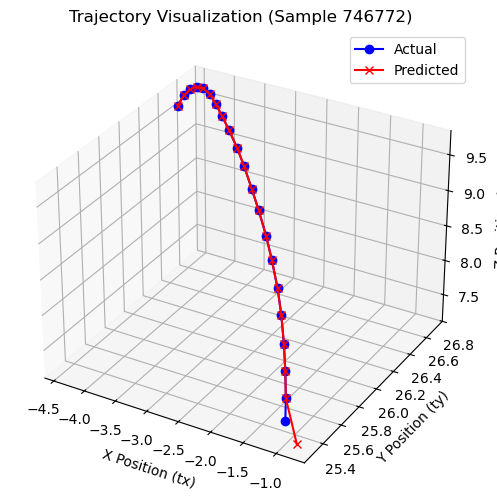

Sample 472558: True Position: [35.15475  16.555307 19.719898] | Predicted Position: [[35.137215 16.360363 19.73227 ]]


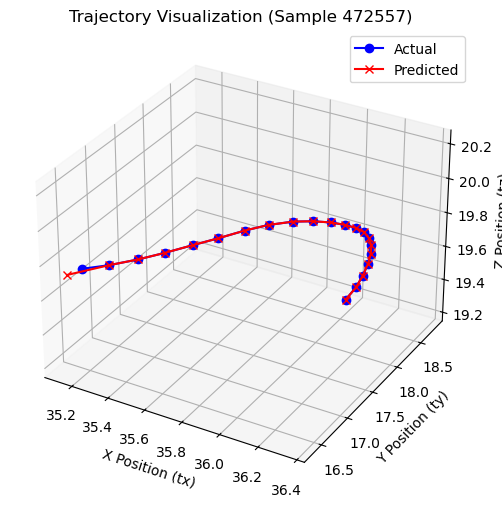

Sample 257591: True Position: [18.087875 27.7082    9.986687] | Predicted Position: [[18.26946  27.4488    9.966486]]


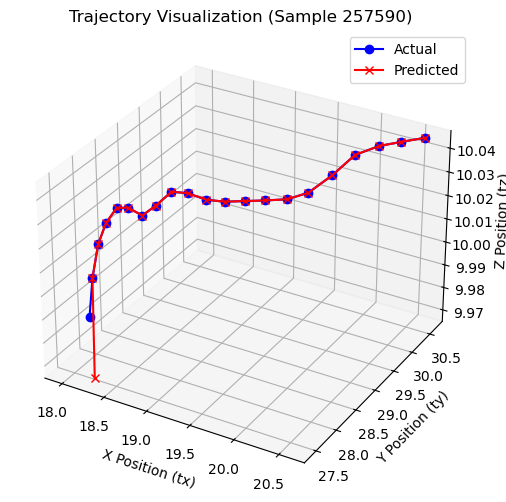

Sample 315896: True Position: [ 24.36286   -33.961678    6.7194123] | Predicted Position: [[ 24.255735 -34.15618    6.734489]]


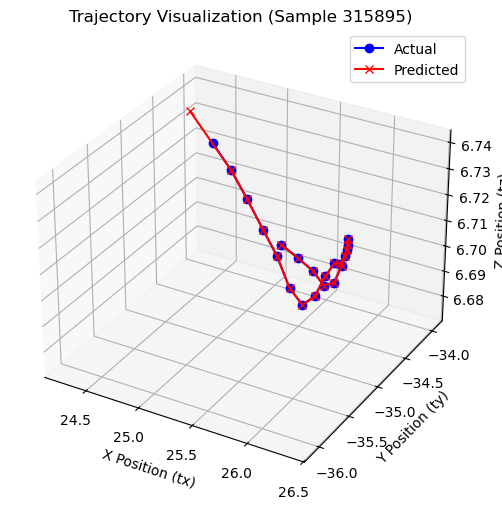

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Visualization after training
def plot_trajectory(actual, predicted, idx):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(actual[:, 0], actual[:, 1], actual[:, 2], label="Actual", color='b', marker='o')
    ax.plot(predicted[:, 0], predicted[:, 1], predicted[:, 2], label="Predicted", color='r', marker='x')
    ax.set_xlabel("X Position (tx)")
    ax.set_ylabel("Y Position (ty)")
    ax.set_zlabel("Z Position (tz)")
    ax.set_title(f"Trajectory Visualization (Sample {idx})")
    ax.legend()
    plt.show()

# 2. Predict and plot for a few samples
model.eval()

# Take a few random samples from the dataset (e.g., 5 samples)
sample_indices = np.random.choice(len(X), 5, replace=False)

for idx in sample_indices:
    sample_input = X[idx:idx+1].to(device)  # Get input sequence
    true_next_position = y[idx].cpu().numpy()  # True next position

    # Predict the next position
    with torch.no_grad():
        predicted_position = model(sample_input).cpu().numpy()

    # Plot the actual vs predicted trajectory
    print(f"Sample {idx + 1}: True Position: {true_next_position} | Predicted Position: {predicted_position}")
    
    # Visualize the trajectory over time (show actual vs predicted paths)
    actual_trajectory = positions[idx:idx + SEQ_LEN + 1]
    predicted_trajectory = np.vstack([actual_trajectory[:-1], predicted_position])
    
    plot_trajectory(actual_trajectory, predicted_trajectory, idx)
